Test whether neg voja with recurrence can actually learn an association

In [1]:
import os
from collections import namedtuple

import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import nengo
from nengo.utils.ensemble import tuning_curves
import nengolib
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import (BasicVecFeed, meg_from_spikes, numpy_bytes_to_str,
                                         gen_added_strings, norm_spa_vecs)
from nengo_learn_assoc_mem.paths import data_path

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Setup

In [2]:
neg_voja_lr = 8e-6 # the range of valid learning rates is (1e-5, 9e-6). WHAT?
intercept = 0.15
n_repeats = 4

load_path = os.path.join(data_path, "neg_voja_enc", f"neg_voja_enc_{n_repeats}_{intercept}_{neg_voja_lr}.h5")

with h5py.File(load_path, "r") as fi:
    print(list(fi.keys()))

    fan1 = numpy_bytes_to_str(fi['fan1'])
    fan2 = numpy_bytes_to_str(fi['fan2'])
    foil1 = numpy_bytes_to_str(fi['foil1'])
    foil2 = numpy_bytes_to_str(fi['foil2'])

    v_strs = numpy_bytes_to_str(fi['vocab_strings'])
    v_vecs = list(fi['vocab_vectors'])
    dimensions = fi['vocab_vectors'].attrs['dimensions']
    
    fin_enc = np.array(fi['encoders'])[-1]
    n_neurons = fin_enc.shape[0]
    intercepts = np.ones(n_neurons) * intercept
    seed = fi['encoders'].attrs['seed']

    dt = fi['t_range'].attrs['dt']

['encoders', 'fan1', 'fan2', 'foil1', 'foil2', 'response', 't_range', 'vocab_strings', 'vocab_vectors']


In [81]:
# with h5py.File(os.path.join(data_path, "neg_voja_weights", "awk_intercept_match_weights.h5"), "r") as fi:
    
#     rec_weights = np.array(fi['weights'])

In [3]:
vocab = spa.Vocabulary(dimensions)
for val, vec in zip(v_strs, v_vecs):
    vocab.add(val, vec)

fan1_pair_vecs = norm_spa_vecs(vocab, fan1)
fan2_pair_vecs = norm_spa_vecs(vocab, fan2)
foil1_pair_vecs = norm_spa_vecs(vocab, foil1)
foil2_pair_vecs = norm_spa_vecs(vocab, foil2)

In [4]:
t_pause = 0.2
t_present = 0.3

t_each = t_pause + t_present
td_each = int(t_each/dt)
td_pause = int(t_pause/dt)

In [5]:
fan1_slc = slice(td_pause, td_each*len(fan1_pair_vecs)+td_pause)
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+td_each*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+td_each*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+td_each*len(foil2_pair_vecs))

In [6]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'vecs', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, np.array(fan1_pair_vecs), fan1_slc),
                 "fan2": SlcStim(2, True, np.array(fan2_pair_vecs), fan2_slc),
                 "foil1": SlcStim(1, False, np.array(foil1_pair_vecs), foil1_slc),
                 "foil2": SlcStim(2, False, np.array(foil2_pair_vecs), foil2_slc)}

## Train

In [7]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs

### Analytically

In [8]:
with nengo.Network(seed=seed) as decode_model:
    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)

with nengo.Simulator(decode_model) as decode_sim:
    pass

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [9]:
solver = nengo.solvers.LstsqL2(reg=0.02)

In [10]:
_, activities = tuning_curves(ens, decode_sim, inputs=np.array(feed_vecs))
dec, rmse = solver(activities, feed_vecs)
dec = dec.T

# Test

In [11]:
rec_weights = np.zeros((n_neurons, n_neurons))

In [12]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

In [13]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    correct = nengo.Node(feed.get_answer)
    pause = nengo.Node(lambda t: feed.paused)
    output = nengo.Node(size_in=dimensions)
    comp_nd = nengo.Node(lambda t, x: np.dot(x[:dimensions], x[dimensions:]),
                         size_in=2*dimensions, size_out=1)
    meg_nd = nengo.Node(lambda t, x: np.sum(x),
                        size_in=n_neurons, size_out=1)

    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_weights, synapse=0.01)
    nengo.Connection(ens.neurons, output, transform=dec)
    
    nengo.Connection(output, comp_nd[:dimensions], synapse=None)
    nengo.Connection(correct, comp_nd[dimensions:])
    
    nengo.Connection(ens.neurons, meg_nd, synapse=None)
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_cor = nengo.Probe(correct, synapse=None)
    p_meg = nengo.Probe(meg_nd, synapse=0.01)
    p_out = nengo.Probe(output, synapse=0.01)
    p_comp = nengo.Probe(comp_nd, synapse=0.005)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(feed_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [14]:
test_meg = test_sim.data[p_meg].squeeze()

In [15]:
df_list = []

for key, obj in slc_stim_vecs.items():
    act = test_meg[obj.slc]
    resp = [obj.fan_num] * len(act)
    targ = [obj.targ] * len(act)
    df_list.append(pd.DataFrame({"act": act, "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

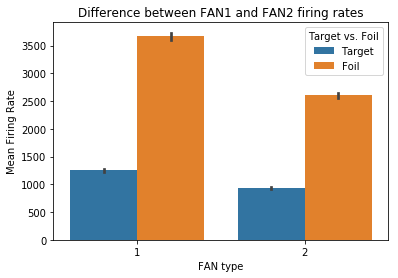

In [17]:
ax = sns.barplot(x="resp", y="act", hue="targ", hue_order=(True, False), data=act_df)

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type")

ax.legend_.set_title("Target vs. Foil")
new_labels = ("Target", "Foil")
for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)

In [18]:
fan1_resp = test_meg[fan1_slc].reshape((-1, td_each))
fan2_resp = test_meg[fan2_slc].reshape((-1, td_each))
foil1_resp = test_meg[foil1_slc].reshape((-1, td_each))
foil2_resp = test_meg[foil2_slc].reshape((-1, td_each))

/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


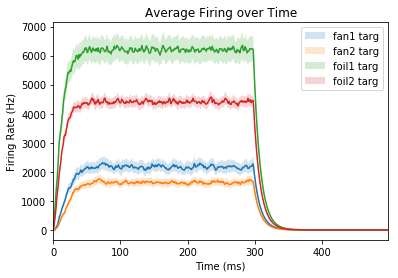

In [19]:
sns.tsplot(fan1_resp, color="C0")
sns.tsplot(fan2_resp, color="C1")
sns.tsplot(foil1_resp, color="C2")
sns.tsplot(foil2_resp, color="C3")

plt.title("Average Firing over Time")
plt.legend(["fan1 targ", "fan2 targ", "foil1 targ", "foil2 targ"], facecolor=None)
plt.ylabel("Firing Rate (Hz)")
plt.xlabel("Time (ms)");

### Show decoding

Constrast the actual decoding (solid lines) with the ideal decoding (dotted lines).

Text(0.5,1,'FAN1 Target Confidence')

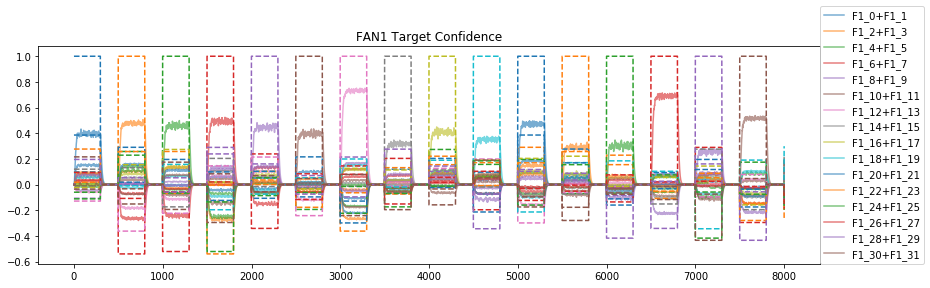

In [48]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][fan1_slc], fan1_pair_vecs), alpha=0.6)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][fan1_slc], fan1_pair_vecs), linestyle="--")
plt.legend(fan1, loc=(1, 0))
plt.title("FAN1 Target Confidence")

Text(0.5,1,'FAN2 Target Confidence')

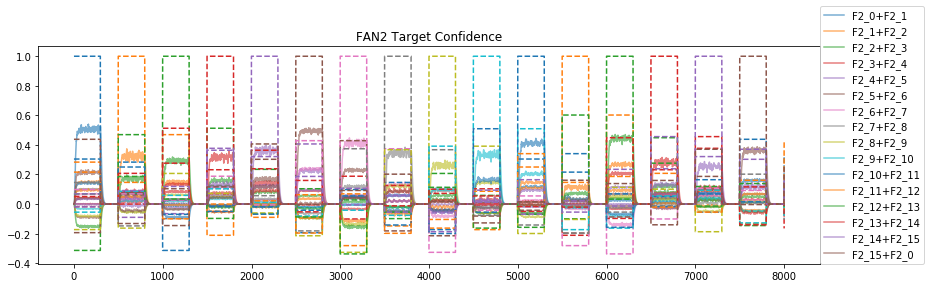

In [49]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][fan2_slc], fan2_pair_vecs), alpha=0.6)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][fan2_slc], fan2_pair_vecs), linestyle="--")
plt.legend(fan2, loc=(1, 0))
plt.title("FAN2 Target Confidence")

Text(0.5,1,'FAN1 Foil Confidence')

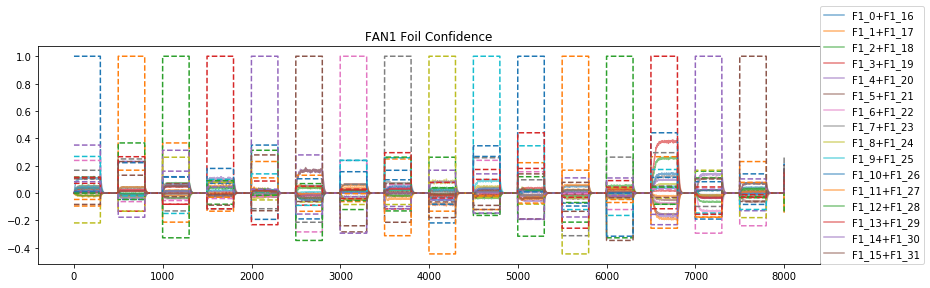

In [50]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][foil1_slc], foil1_pair_vecs), alpha=0.6)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][foil1_slc], foil1_pair_vecs), linestyle="--")
plt.legend(foil1, loc=(1, 0))
plt.title("FAN1 Foil Confidence")

Text(0.5,1,'FAN2 Foil Confidence')

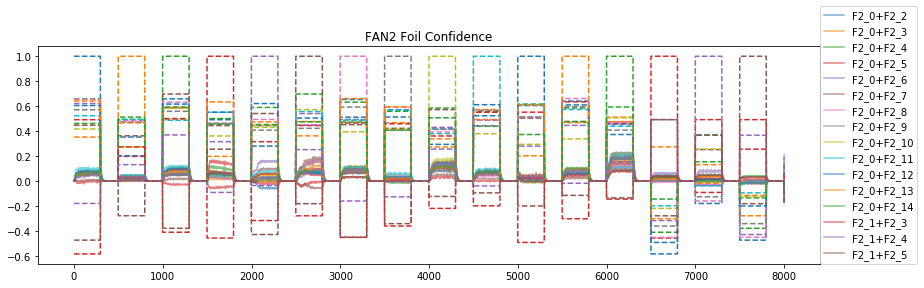

In [51]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][foil2_slc], foil2_pair_vecs), alpha=0.6)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][foil2_slc], foil2_pair_vecs), linestyle="--")
plt.legend(foil2, loc=(1, 0))
plt.title("FAN2 Foil Confidence")

Text(0.5,1,'Input and Recall Match Strength')

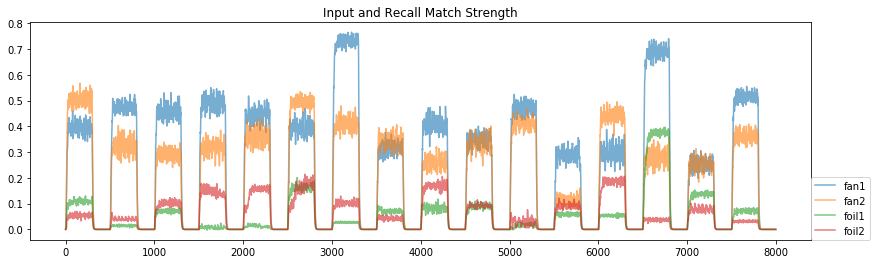

In [52]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.data[p_comp][fan1_slc], alpha=0.6, label="fan1")
plt.plot(test_sim.data[p_comp][fan2_slc], alpha=0.6, label="fan2")
plt.plot(test_sim.data[p_comp][foil1_slc], alpha=0.6, label="foil1")
plt.plot(test_sim.data[p_comp][foil2_slc], alpha=0.6, label="foil2")
plt.legend(loc=(1, 0))
plt.title("Input and Recall Match Strength")

## Compare accuracy

Reaction times too, but only for targets.

In [40]:
def ans_acc(ans: np.ndarray, ans_vocab, num_items: int, td_item: int):
    ind_ans = spa.similarity(ans, ans_vocab).reshape((td_item, num_items, -1), order='F')
    tot_ans = np.sum(ind_ans, axis=0)
    res = np.argmax(tot_ans, axis=1)
    conf = np.max(tot_ans, axis=1)
    return res, conf

In [41]:
fan1_res, fan1_conf = ans_acc(test_sim.data[p_out][fan1_slc], all_fan_vecs, len(fan1), td_each)

In [42]:
print(fan1_res)
print(fan1_conf)
print(np.mean(fan1_conf))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[ 307.8541416   263.50012905  272.9450928   284.23649678  264.99786845
  281.44265784  299.46333036  267.48147077  262.62862993  276.44820691
  290.85065935  258.2352829   259.37454279  293.16693038  248.87871038
  256.27127123]
274.235963845


In [43]:
fan2_res, fan2_conf = ans_acc(test_sim.data[p_out][fan2_slc], all_fan_vecs, len(fan2), td_each)

In [44]:
print(fan2_res)
print(fan2_conf)
print(np.mean(fan2_conf))

[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
[ 258.33921713  256.78617136  265.71591387  270.73908905  224.21527891
  277.05554175  268.74522052  260.89057708  229.09089122  279.77845731
  248.82810789  281.75577672  271.51597896  279.33177821  280.46025727
  267.98352093]
263.826986136


## Compare reaction times

I NO LONGER TRUST THIS CALCULATION.

In [45]:
def ans_conf(ans: np.ndarray, cor: np.ndarray, num_items: int, td_item: int):
    ind_ans = np.sum(ans*cor, axis=1).reshape((td_item, num_items, -1), order='F')
    conf = np.max(np.sum(ind_ans, axis=0), axis=1)
    return conf

In [46]:
ConfSlc = namedtuple("ConfSlc", ("ans_slc", "cor_slc", "n_items"))

In [47]:
confs = {}

for nm, obj in slc_stim_vecs.items():
    conf_res = ans_conf(
        test_sim.data[p_out][obj.slc],
        test_sim.data[p_cor][obj.slc],
        len(obj.vecs), td_each
    )
    confs[nm] = conf_res
    print(nm, np.mean(conf_res))

fan1 258.807613378
fan2 249.03020223
foil1 273.190691319
foil2 262.815993706


In [48]:
conf_df = pd.DataFrame(confs)

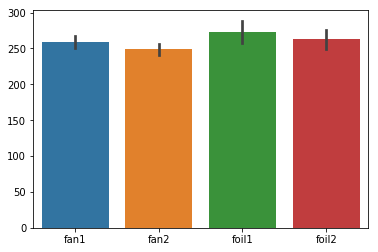

In [49]:
sns.barplot(data=conf_df)

Learning with recurrence works from decoding function 0, but never fully differentiating the foils. However, learning without recurrence does a worse job of seperating foils from targets. Learning from initial decoding works really poorly.